In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from autoencode import Autoencoder
from data_reader import DataReader
from ipywidgets import interact, IntSlider

import keras.callbacks as kc

from sklearn.model_selection import GroupKFold, GroupShuffleSplit

from sklearn.preprocessing import StandardScaler

%matplotlib notebook

In [2]:
filenames = ["X1_train.csv", "X2_train.csv", "X3_train.csv"]

data_reader = DataReader(data_set_filenames=filenames, groups_filename="ID_train.csv")
data = data_reader.combined_data
groups = data_reader.groups
input_shape = (data.shape[1],)

In [3]:
config = {
    "decoder": [
        {
            "kwargs": {
                "activation": "relu",
                "units": 256
            },
            "name": "hidden1_decoder",
            "type": "Dense"
        },
        {
            "kwargs": {
                "activation": "linear",
                "units": 3048
            },
            "name": "output",
            "type": "Dense"
        }
    ],
    "encoder": [
        {
            "kwargs": {
                "activation": "relu",
                "units": 256
            },
            "name": "hidden1_encoder",
            "type": "Dense"
        },
        {
            "kwargs": {
                "rate": 0
            },
            "name": "dropout",
            "type": "Dropout"
        },
        {
            "kwargs": {
                "activation": "sigmoid",
                "units": 512
            },
            "name": "latent",
            "regularizer": {
                "type": "l1",
                "value": 0
            },
            "type": "Dense"
        }
    ]
}

latent_dim = config["encoder"][-1]["kwargs"]["units"]
latent_shape = (latent_dim,)

In [4]:
train_idx, val_idx = next(GroupShuffleSplit().split(data, groups=groups))
data_train, data_val = data.iloc[train_idx], data.iloc[val_idx]

In [5]:
ae = Autoencoder(config["encoder"],
                 config["decoder"],
                 input_shape=input_shape,
                 latent_shape=latent_shape,
                 loss="mean_absolute_error",
                 optimizer_params=None)

In [6]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_val = scaler.transform(data_val)

In [7]:
ae.fit(data_train, epochs=600, validation_data=data_val, callbacks = [kc.EarlyStopping(monitor="val_loss", min_delta=0.000001, patience=10)])

Train on 160 samples, validate on 40 samples
Epoch 1/600
160/160 [==============================] - 0s 2ms/step - loss: 0.7432 - val_loss: 0.7639
Epoch 2/600
160/160 [==============================] - 0s 576us/step - loss: 0.7299 - val_loss: 0.7561
Epoch 3/600
160/160 [==============================] - 0s 565us/step - loss: 0.7197 - val_loss: 0.7488
Epoch 4/600
160/160 [==============================] - 0s 581us/step - loss: 0.7094 - val_loss: 0.7402
Epoch 5/600
160/160 [==============================] - 0s 542us/step - loss: 0.6962 - val_loss: 0.7304
Epoch 6/600
160/160 [==============================] - 0s 539us/step - loss: 0.6800 - val_loss: 0.7191
Epoch 7/600
160/160 [==============================] - 0s 564us/step - loss: 0.6613 - val_loss: 0.7089
Epoch 8/600
160/160 [==============================] - 0s 576us/step - loss: 0.6437 - val_loss: 0.7021
Epoch 9/600
160/160 [==============================] - 0s 589us/step - loss: 0.6287 - val_loss: 0.6968
Epoch 10/600
160/160 [========

In [8]:
predictions_val = ae.predict(data_val)

In [9]:
lengths = [d.shape[1] for d in data_reader.seperate_data]
separators = np.cumsum([0] + lengths)
print(lengths)



[144, 1456, 1448]


# Visualisation time

<IPython.core.display.Javascript object>


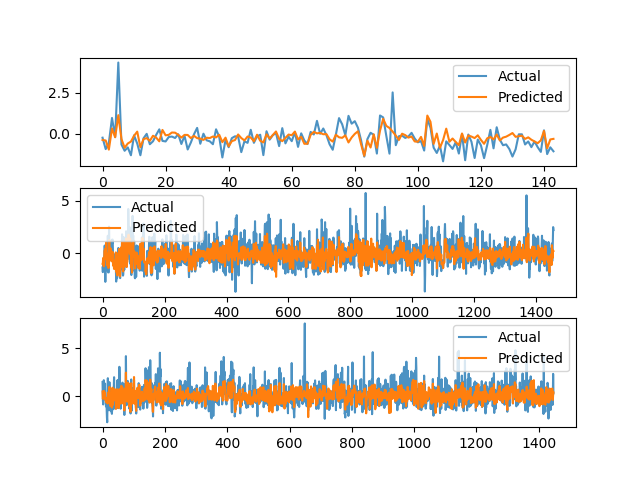

interactive(children=(IntSlider(value=0, description='idx', max=39), Checkbox(value=False, description='residu…

In [17]:
fig = plt.figure()
subs = [fig.add_subplot(3,1,i+1) for i in range(3)]

def plot_prediction(true_values, predicted_values, subplot, residual):
    if residual:
        subplot.plot(true_values-predicted_values)
        subplot.legend(['Residuals'])
    else:
        subplot.plot(true_values, alpha=0.8)
        subplot.plot(predicted_values, alpha=1)
        subplot.legend(['Actual','Predicted'])

@interact(idx=IntSlider(min=0,max=data_val.shape[0]-1), residual=False)
def visualise(idx, residual=False):
    for i, sub in enumerate(subs):
        sub.clear()
        plot_prediction(data_val[idx, separators[i]:separators[i+1]],
                        predictions_val[idx, separators[i]:separators[i+1]],
                        sub, residual)

## Ideas

 * Fixed axes
 * Only one legend
 * Standardise
 * Plot size
 * Line plots or something else?

In [11]:
data_val.shape

(40, 3048)

In [12]:
144+1456+1448

3048

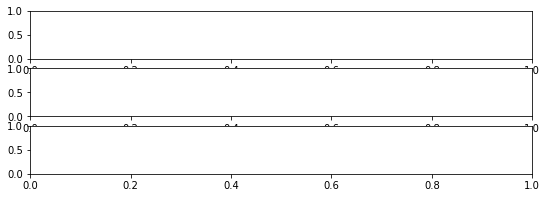

interactive(children=(IntSlider(value=0, description='idx', max=40), Checkbox(value=False, description='residu…

In [13]:
fig = plt.figure(figsize=(9,3))
subs = [fig.add_subplot(3,1,i+1) for i in range(3)]

def plot_prediction2(true_values, predicted_values, subplot, residual):
    if residual:
        subplot.imshow(np.tile(true_values-predicted_values,(100,1)), 
                       interpolation='none')
        #subplot.plot(true_values-predicted_values)
        #subplot.legend(['Residuals'])
    else:
        n = len(predicted_values)
        viz = np.zeros([100,n])
        viz[:50] = predicted_values
        viz[50:] = true_values
        subplot.imshow(viz,interpolation='none',cmap='viridis')
        #subplot.plot(predicted_values, alpha=0.8)
        #subplot.plot(true_values, alpha=0.8)
        #subplot.legend(['Predicted', 'Actual'])

@interact(idx=IntSlider(min=0,max=data_val.shape[0]), residual=False)
def visualise2(idx, residual=False):
    for i, sub in enumerate(subs):
        sub.clear()
        plot_prediction2(data_val[idx, separators[i]:separators[i+1]],
                        predictions_val[idx, separators[i]:separators[i+1]],
                        sub, residual)